# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [256]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

# 1. Load Dataset

In [257]:
df = pd.read_csv('./data/final_0507.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
#df.set_index('Date', inplace=True)

In [277]:
df.rename(columns={'TARGET':'oversea_inflow'}, inplace=True)

In [278]:
df['target'] = df['oversea_inflow'].diff()

In [279]:
cols = ['EURO_conf',
 'CHINA_conf',
 'ASIA_conf',
 'AMERICA_conf',]

In [280]:
cols

['EURO_conf', 'CHINA_conf', 'ASIA_conf', 'AMERICA_conf']

In [281]:
t_cols = []
for col in cols:
    tmp = '{}_1'.format(col)
    t_cols.append(tmp)
    df[tmp] = df['{}'.format(col)].diff()

In [282]:
df.isnull().sum()

EURO_conf         0
CHINA_conf        0
ASIA_conf         0
AMERICA_conf      0
EURO_roam         0
CHINA_roam        0
ASIA_roam         0
AMERICA_roam      0
oversea_inflow    0
NEWS              0
target            1
EURO_conf_1       1
CHINA_conf_1      1
ASIA_conf_1       1
AMERICA_conf_1    1
dtype: int64

In [283]:
t_cols

['EURO_conf_1', 'CHINA_conf_1', 'ASIA_conf_1', 'AMERICA_conf_1']

In [284]:
df.head()

,EURO_conf,CHINA_conf,ASIA_conf,AMERICA_conf,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1
Date,,,,,,,,,,,,,,,
2020-01-22,0,548,5,1,1955.0,3014.0,8946.0,701.0,1,430,NaN,NaN,NaN,NaN,NaN
2020-01-23,0,643,9,1,1913.0,2677.0,7924.0,943.0,1,452,0.0,0.0,95.0,4.0,0.0
2020-01-24,2,920,15,2,2286.0,2197.0,7356.0,864.0,2,421,1.0,2.0,277.0,6.0,1.0
2020-01-25,3,1406,17,2,1472.0,1825.0,7518.0,828.0,2,506,0.0,1.0,486.0,2.0,0.0
2020-01-26,3,2075,22,5,1932.0,3252.0,11149.0,900.0,3,552,1.0,0.0,669.0,5.0,3.0


In [285]:
df.loc['2020-01-22',t_cols] = 0
df.target.iloc[0] = 0

In [286]:
# 일일 해외유입 확진자를 구할때 첫번째 로우는 NaN이기 때문에 0값을 넣어준다.
df['target'][0] = 0

In [287]:
df.drop(cols, axis=1, inplace=True)

In [288]:
df.tail()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1
Date,,,,,,,,,,,
2020-04-24,39.0,197.0,311.0,99.0,1023,1708,2.0,1900.0,15.0,4431.0,36188.0
2020-04-25,34.0,73.0,298.0,108.0,1027,1107,4.0,13407.0,10.0,4266.0,32796.0
2020-04-26,62.0,126.0,294.0,100.0,1037,1176,10.0,10354.0,3.0,4027.0,27631.0
2020-04-27,50.0,67.0,194.0,106.0,1044,1353,7.0,12612.0,6.0,4311.0,22412.0
2020-04-28,15.0,143.0,224.0,102.0,1056,999,12.0,11645.0,22.0,3456.0,24385.0


In [258]:
df.Date = pd.to_datetime(df.Date)

In [259]:
df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

## lag 변수 생성

In [260]:
lag_amount = 3

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['target'].shift(i+1)
    
df.dropna(inplace=True)

In [261]:
df.head()

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,US_roam,CN_roam,news,covid_tr,coro_tr,target,dayofweek,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,828,1403,506.0,0.0,7.0,0.0,5,1.0,0.0,0.0
2020-01-26,0,0,0,0,0,1,1,3,0,0,...,900,2508,552.0,0.0,8.0,1.0,6,0.0,1.0,0.0
2020-01-27,0,0,0,0,0,1,1,0,0,0,...,1130,3133,576.0,0.0,13.0,1.0,0,1.0,0.0,1.0
2020-01-28,0,0,0,0,0,0,3,0,0,0,...,1009,2150,711.0,0.0,17.0,0.0,1,1.0,1.0,0.0
2020-01-29,0,0,0,0,0,0,0,0,4,0,...,829,1966,906.0,0.0,12.0,0.0,2,0.0,1.0,1.0


In [262]:
df.tail()

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,US_roam,CN_roam,news,covid_tr,coro_tr,target,dayofweek,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,52,153,1104.0,48.0,18.0,8.0,4,4.0,5.0,12.0
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,108,85,732.0,43.0,18.0,8.0,5,8.0,4.0,5.0
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,116,146,821.0,55.0,18.0,10.0,6,8.0,8.0,4.0
2020-05-04,6,0,199,262,10581,3,2,22335,567,3990,...,72,97,1331.0,30.0,17.0,8.0,0,10.0,8.0,8.0
2020-05-05,0,0,318,199,10102,2,0,23976,462,4411,...,119,91,793.0,30.0,17.0,3.0,1,8.0,10.0,8.0


# Data Exploration

In [264]:
# 결측치 확인
df.isnull().sum().sum()

0

In [265]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (102, 87)
target feature shape: (102,)


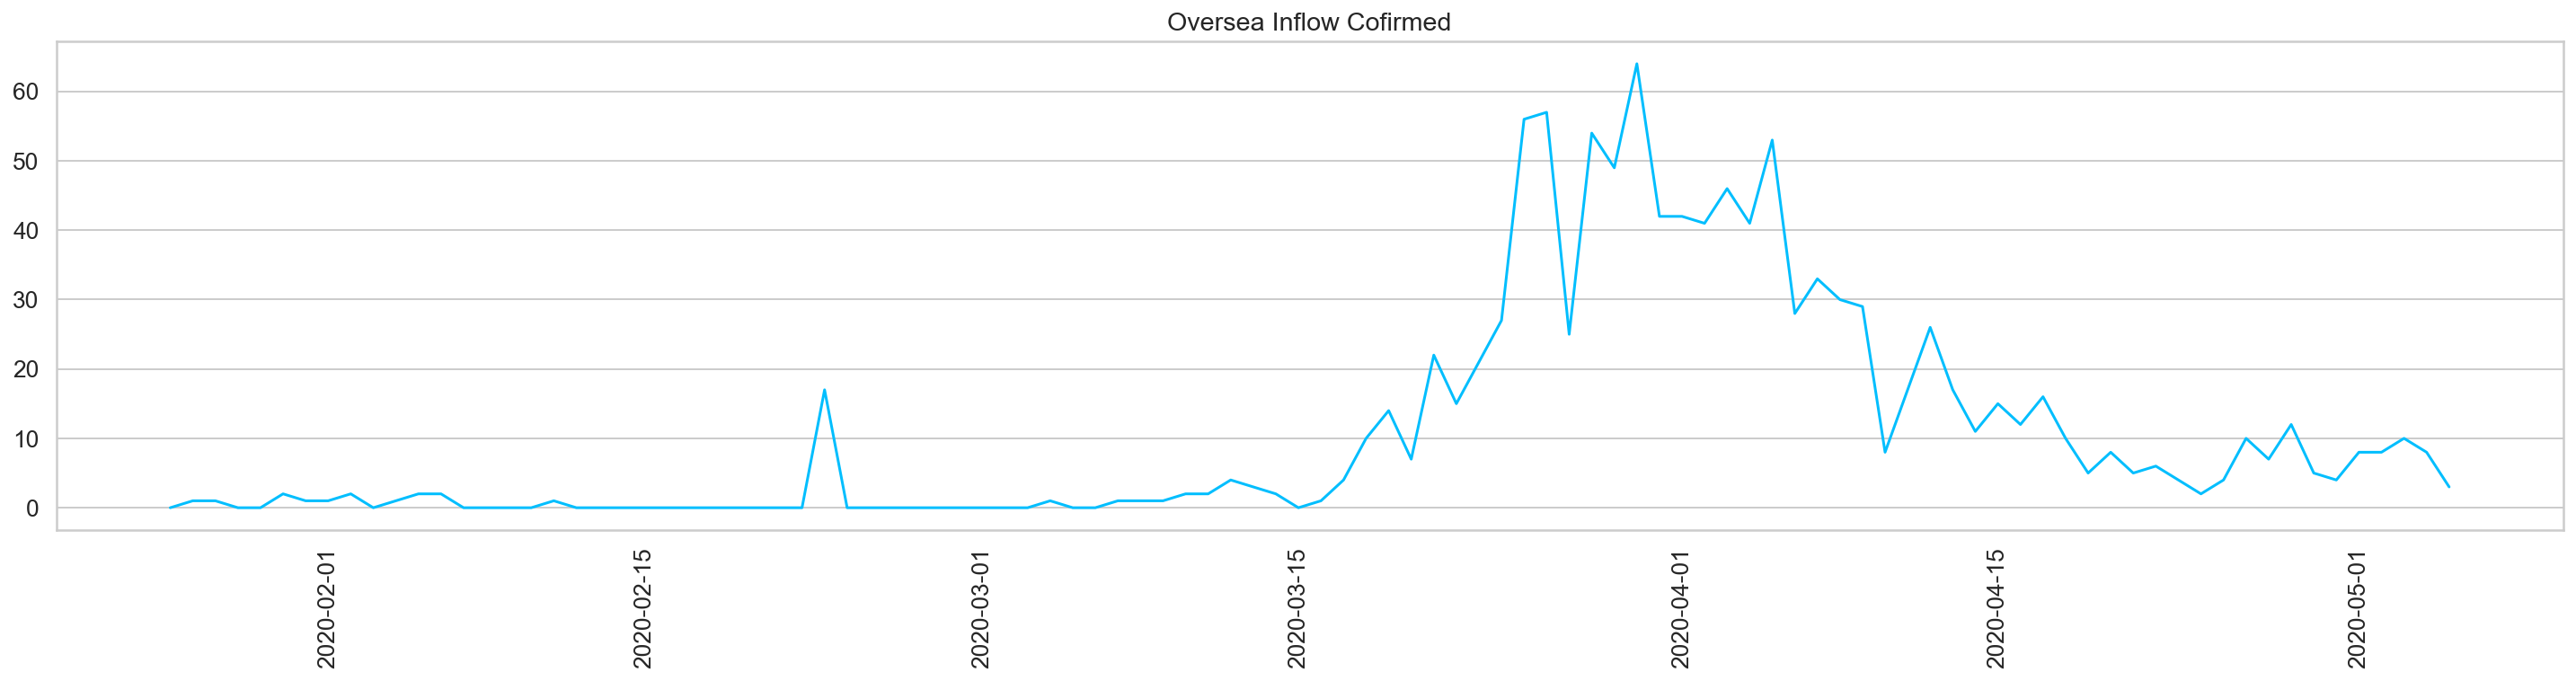

In [266]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

In [267]:
X_cols = list(df.columns)
X_cols.remove('target')

In [268]:
# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

In [269]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [270]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (88, 86)
test set :  (14, 86)


In [271]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [272]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [273]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [274]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([86, 1, 86])
X_test : torch.Size([12, 1, 86])
y_train : torch.Size([86, 1])
y_test : torch.Size([12, 1])


# Building a Model

In [275]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [276]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [277]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=32
n_layers=4
lr=1e-4
num_epochs=400

# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.0859 test loss: 0.004
Epoch 10 train loss: 0.0819 test loss: 0.0027
Epoch 20 train loss: 0.0784 test loss: 0.0021
Epoch 30 train loss: 0.0753 test loss: 0.0021
Epoch 40 train loss: 0.0724 test loss: 0.0026
Epoch 50 train loss: 0.0697 test loss: 0.0036
Epoch 60 train loss: 0.0669 test loss: 0.0053
Epoch 70 train loss: 0.064 test loss: 0.0076
Epoch 80 train loss: 0.0608 test loss: 0.0109
Epoch 90 train loss: 0.0571 test loss: 0.0153
Epoch 100 train loss: 0.0527 test loss: 0.0212
Epoch 110 train loss: 0.0475 test loss: 0.0291
Epoch 120 train loss: 0.0415 test loss: 0.0401
Epoch 130 train loss: 0.035 test loss: 0.0553
Epoch 140 train loss: 0.0289 test loss: 0.0727
Epoch 150 train loss: 0.0242 test loss: 0.0895
Epoch 160 train loss: 0.0211 test loss: 0.0992
Epoch 170 train loss: 0.0188 test loss: 0.0938
Epoch 180 train loss: 0.0165 test loss: 0.0764
Epoch 190 train loss: 0.0143 test loss: 0.0592
Epoch 200 train loss: 0.0122 test loss: 0.0424
Epoch 210 train loss: 0.010

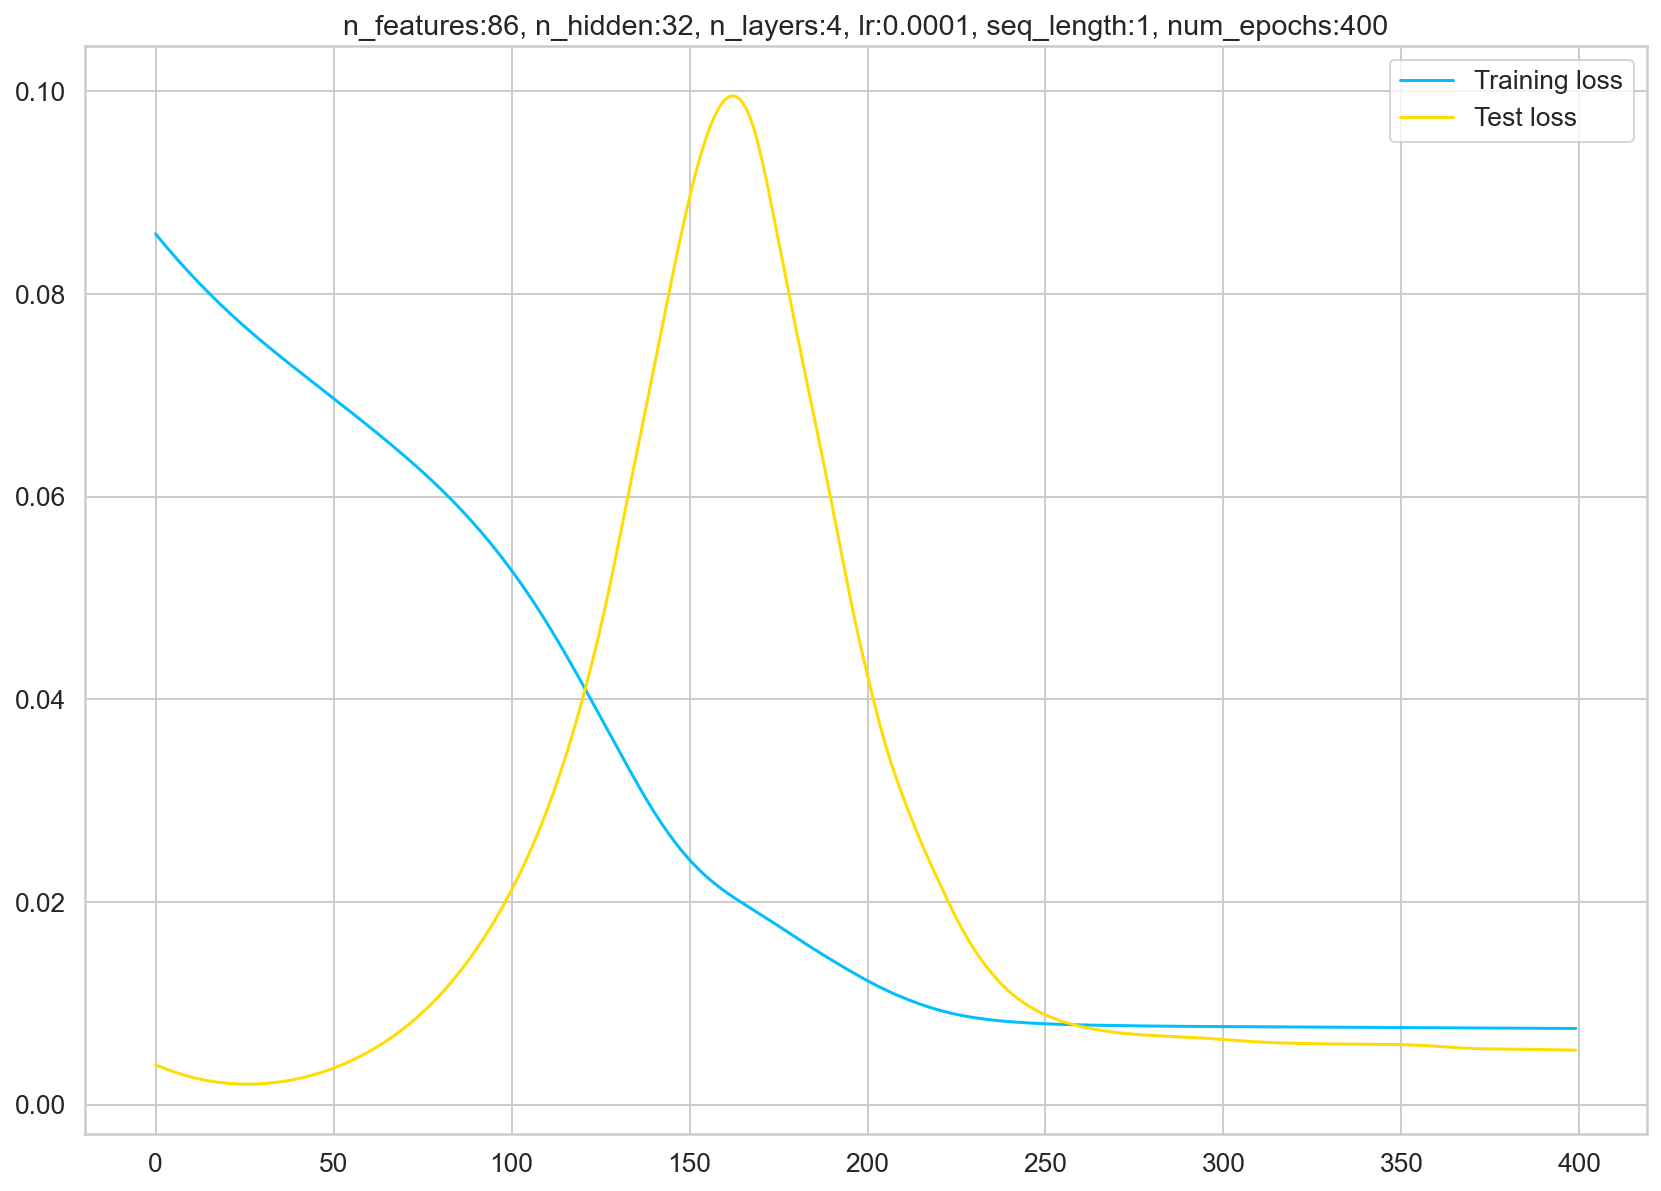

In [278]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [309]:
# 모델 저장
PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
torch.save(model, PATH)
# 모델 불러오기
model = torch.load(PATH)
#model.eval()

# Predicting daily cases

In [279]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [280]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [281]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
pred_values_ceiled

[10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 10, 9]

In [282]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [283]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [284]:
# validation score
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [285]:
score

68.13880126182966

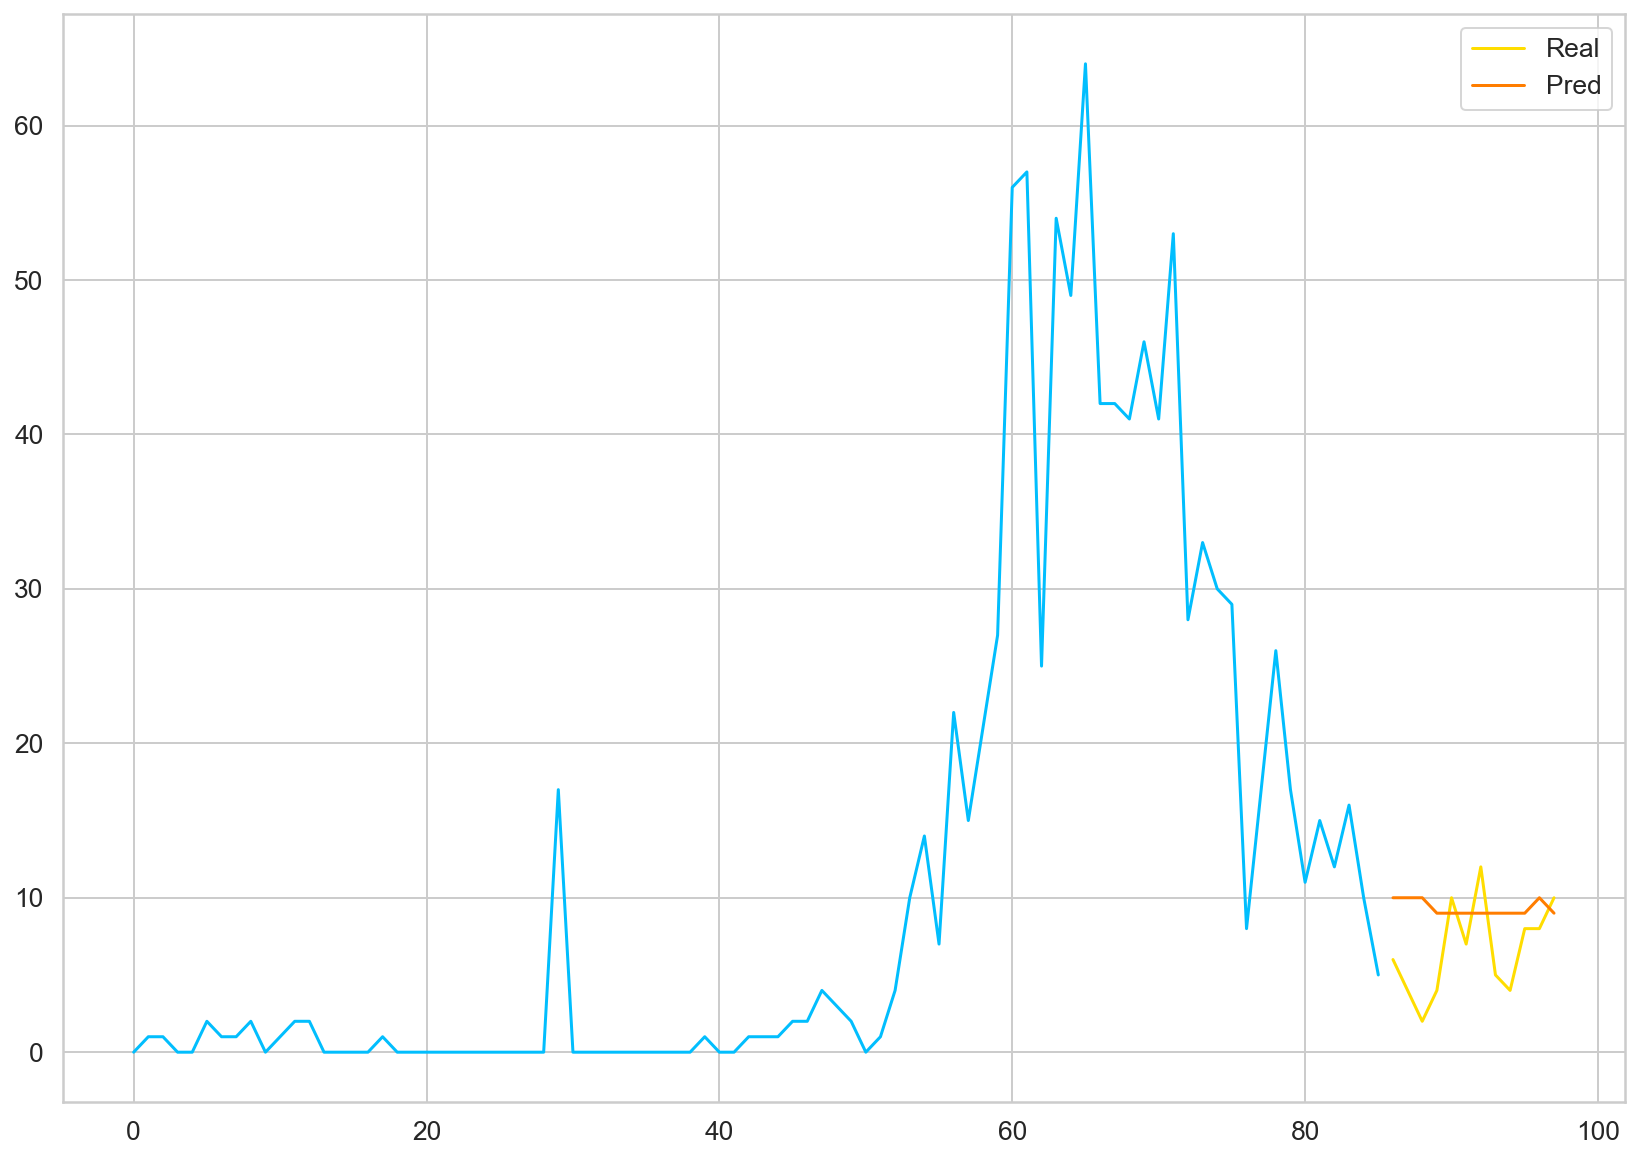

In [286]:
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
plt.legend()

# Use all data for training

In [287]:
# X변수들과 y변수 구분
X_all = df.iloc[:,:-1]
y_all = df.iloc[:,-1]

In [288]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [289]:
y_all

array([0.      , 0.      , 0.015625, 0.      , 0.015625, 0.015625,
       0.      , 0.      , 0.03125 , 0.015625, 0.015625, 0.03125 ,
       0.      , 0.015625, 0.03125 , 0.03125 , 0.      , 0.      ,
       0.      , 0.      , 0.015625, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.265625, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.015625, 0.      , 0.      , 0.015625, 0.015625, 0.015625,
       0.03125 , 0.03125 , 0.0625  , 0.046875, 0.03125 , 0.      ,
       0.015625, 0.0625  , 0.15625 , 0.21875 , 0.109375, 0.34375 ,
       0.234375, 0.328125, 0.421875, 0.875   , 0.890625, 0.390625,
       0.84375 , 0.765625, 1.      , 0.65625 , 0.65625 , 0.640625,
       0.71875 , 0.640625, 0.828125, 0.4375  , 0.515625, 0.46875 ,
       0.453125, 0.125   , 0.265625, 0.40625 , 0.265625, 0.171875,
       0.234375, 0.1875  , 0.25    , 0.15625 , 0.078125, 0.125

In [290]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 86)
y_all :  (102,)


In [291]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [292]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [293]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.13281899690628052
Epoch 10 train loss: 0.1249164342880249
Epoch 20 train loss: 0.11752418428659439
Epoch 30 train loss: 0.1102963536977768
Epoch 40 train loss: 0.10361931473016739
Epoch 50 train loss: 0.09719586372375488
Epoch 60 train loss: 0.09091353416442871
Epoch 70 train loss: 0.08475460857152939
Epoch 80 train loss: 0.07867658883333206
Epoch 90 train loss: 0.07252342998981476
Epoch 100 train loss: 0.0661926195025444
Epoch 110 train loss: 0.059570830315351486
Epoch 120 train loss: 0.05260360985994339
Epoch 130 train loss: 0.04552104324102402
Epoch 140 train loss: 0.03882146254181862
Epoch 150 train loss: 0.03305397555232048
Epoch 160 train loss: 0.028655128553509712
Epoch 170 train loss: 0.025650573894381523
Epoch 180 train loss: 0.023592187091708183
Epoch 190 train loss: 0.021665064617991447
Epoch 200 train loss: 0.01935030147433281
Epoch 210 train loss: 0.015922658145427704
Epoch 220 train loss: 0.01335859764367342
Epoch 230 train loss: 0.011426972225308418

# Predicting future cases

In [294]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [295]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [296]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[10, 9, 8, 7, 6, 6, 5, 4, 3, 3, 2, 2, 1, 1]

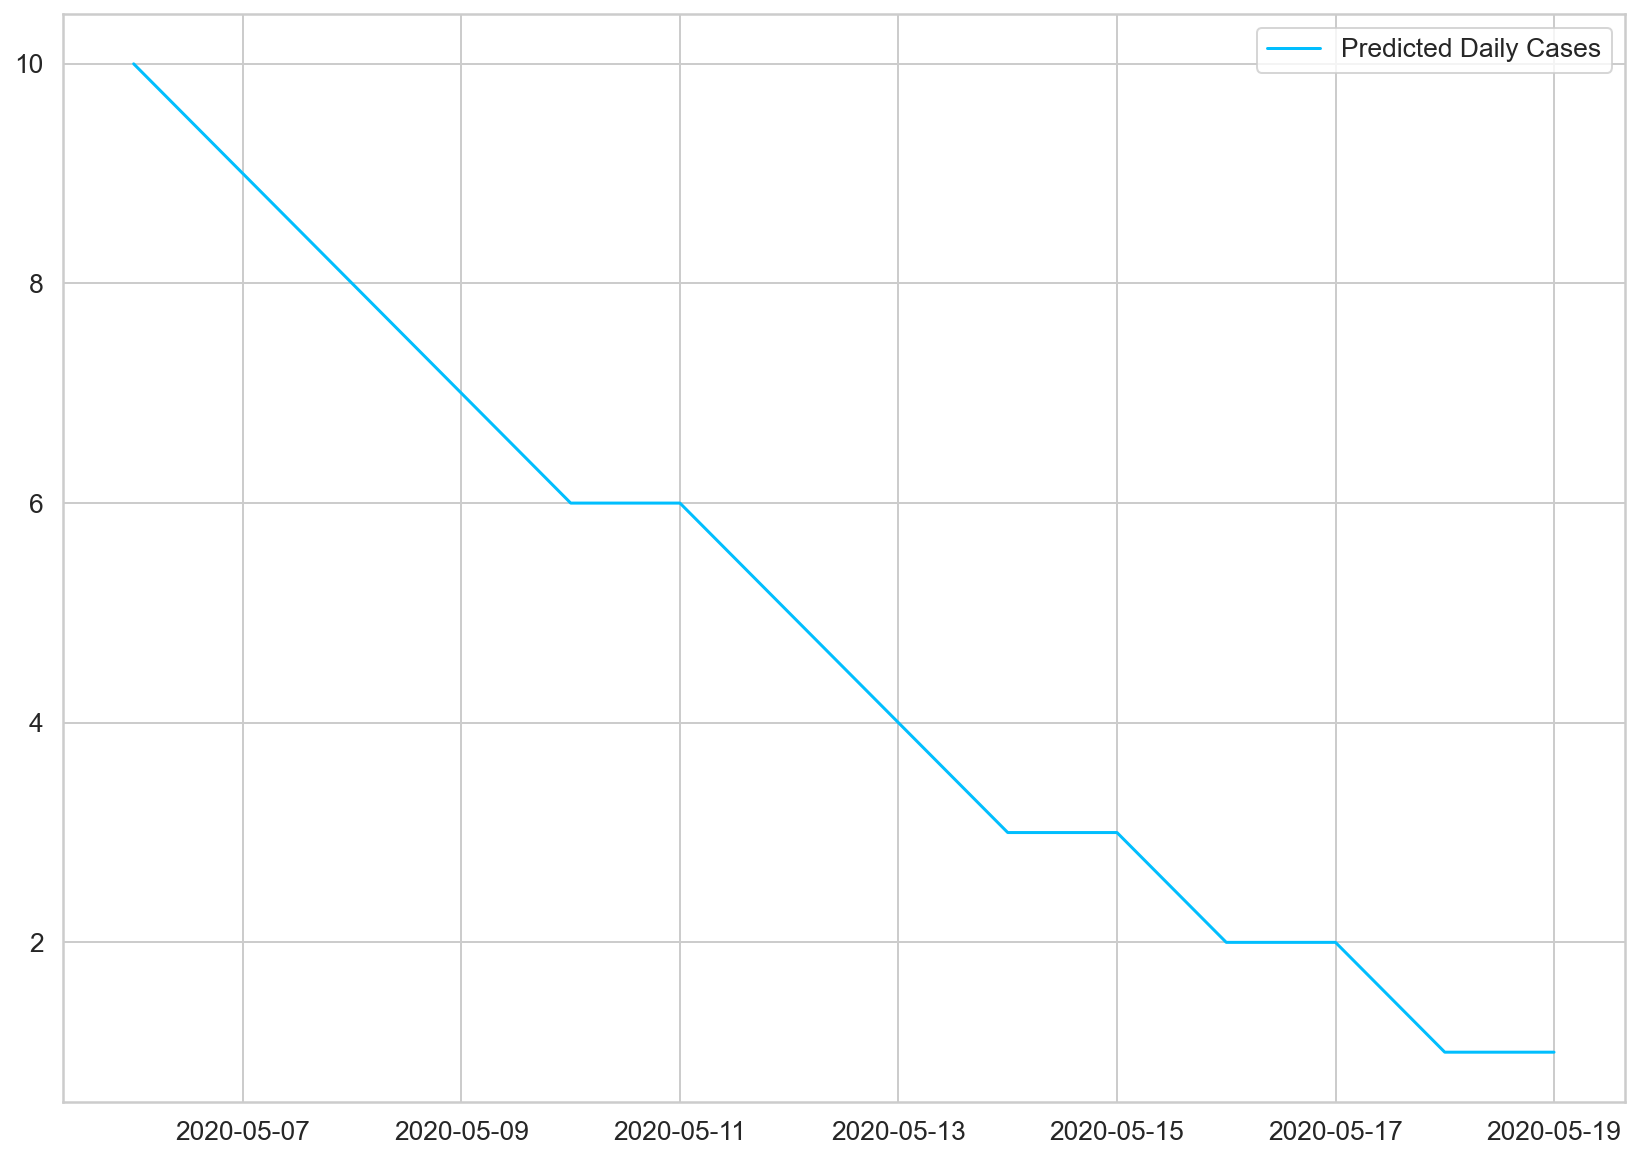

In [297]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [298]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [299]:
df['target']

Date
2020-01-25     0.0
2020-01-26     1.0
2020-01-27     1.0
2020-01-28     0.0
2020-01-29     0.0
              ... 
2020-05-01     8.0
2020-05-02     8.0
2020-05-03    10.0
2020-05-04     8.0
2020-05-05     3.0
Name: target, Length: 102, dtype: float64

In [300]:
preds_

,0
2020-05-06,10
2020-05-07,9
2020-05-08,8
2020-05-09,7
2020-05-10,6
2020-05-11,6
2020-05-12,5
2020-05-13,4
2020-05-14,3
2020-05-15,3


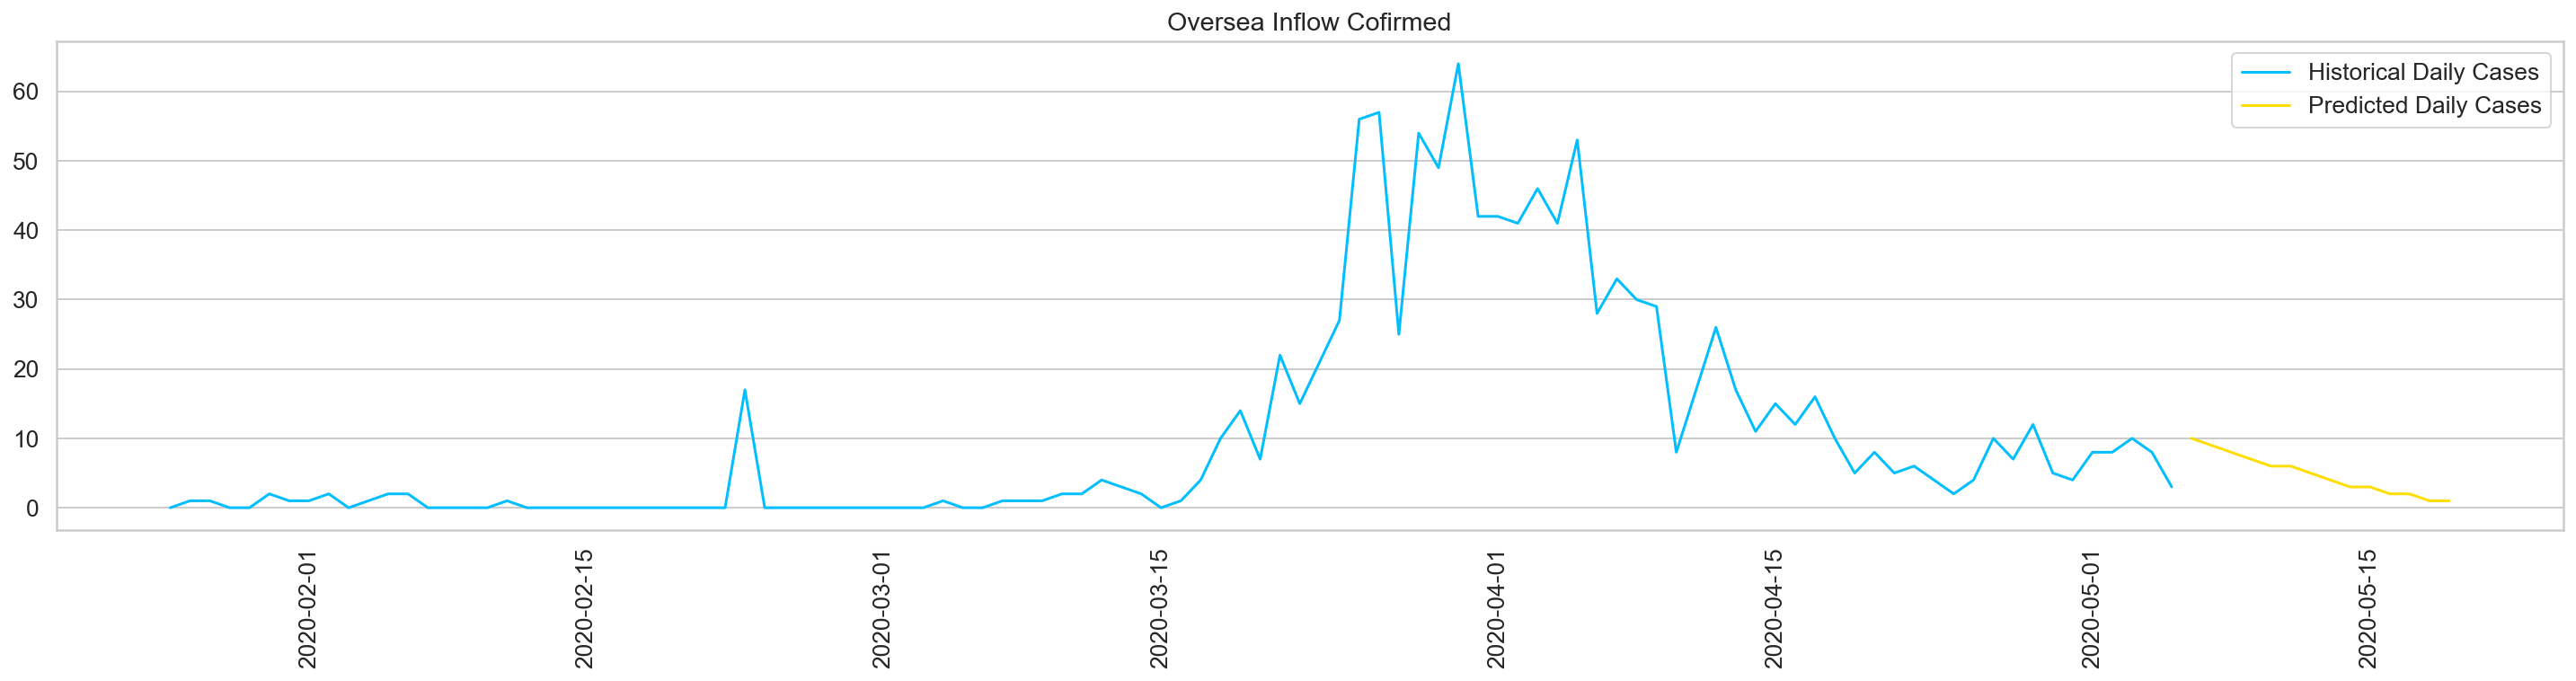

In [301]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();